#IRWA Project Part 1

Group team: G_101_7

Group members:

*   Mireia Carbó
*   Aitana González
*   Raquel Sans



##0. Setup and Imports

In [ ]:
### CONNECT TO DRIVE

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### UPLOADS OF DOCS

docs_path_json = '/content/drive/Shareddrives/IRWA/Part1/IRWA_data_2023/Rus_Ukr_war_data.json'
docs_path_csv = '/content/drive/Shareddrives/IRWA/Part1/IRWA_data_2023/Rus_Ukr_war_data_ids.csv'

In [ ]:
### IMPORTS

import json
import csv
import pandas as pd
import numpy as np
import re
import datetime
###
import nltk
nltk.download('stopwords')
###
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import warnings
warnings.filterwarnings('ignore')
###
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##1. Pre-Process the Code

### Funciones desarrolladas

In [ ]:
### CLEAN FUNCTION

def clean(text):
  # Transform to lowercase
  cleanTxt = text.lower()

  # Removing the urls from tweets, starts with https
  cleanTxt = re.sub('https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  # Removing the entire hashtags, starts with '#'
  cleanTxt = re.sub(r'#\w+\s*', '', cleanTxt)

  # Removing nonalphanumeric
  cleanTxt = re.sub(r'[\W]+', ' ', cleanTxt)
  cleanTxt = re.sub(r'[\_]+', '', cleanTxt)

  return cleanTxt

In [ ]:
### BUILD TERMS FUNCTION

def build_terms(text):
  stemmer = PorterStemmer()
  stop_words = set(stopwords.words("english"))

  # Clean text
  text = clean(text)

  # Tokenize the text to get a list of terms
  text = text.split()

  # Eliminate the stopwords (HINT: use List Comprehension)
  text = [word for word in text if word not in stop_words]

  # Perform stemming (HINT: use List Comprehension)
  text = [stemmer.stem(word) for word in text]

  return text

In [ ]:
### FUNCTION TO OBTAIN THE DIFFERENT WORDS OF A HASHTAG

def separate_by_words(input_string):
    words = re.findall(r'[A-Z][a-z]*', input_string)

    # If there is only one or none words
    if (words == None or len(words) == 0):
      return input_string

    # If there are 2 or more identified words
    else:
      return ' '.join(words)

In [ ]:
### FUNCTION TO OBTAIN THE ORIGINAL HASHTAGS OF A TWEET (IN A LIST)

def getHashtagsFromTweet_Original(tweet):
  length_hashtags = len(tweet["entities"]["hashtags"]) # number of hashtags used in the tweet
  hashtags = [] # empty hashtag list

  # Loop the list of hashtags used in the tweet
  for i in range(length_hashtags):
    hashtags.append('#' + tweet["entities"]["hashtags"][i]["text"])

  # Return the list of hashtags used
  return hashtags

In [ ]:
### FUNCTION TO OBTAIN THE HASHTAGS OF A TWEET (IN A LIST)

def getHashtagsFromTweet(tweet):
  length_hashtags = len(tweet["entities"]["hashtags"]) # number of hashtags used in the tweet
  hashtags = [] #empty hashtag list

  # Loop the list of hashtags used in the tweet
  for i in range(length_hashtags):
    hash = separate_by_words(tweet["entities"]["hashtags"][i]["text"])
    hashtags.append(hash)

  # Return the list of hashtags used
  return hashtags

In [ ]:
# FUNCTION TO OBTAIN THE DESIRED INFORMATION OF EACH TWEET (IN A DICTIONARY)

def getTweetInfo(tweet):
  tweet_dict = {}
  # Tweet ID
  tweet_dict['ID'] = tweet['id']
  # Text of the Tweet
  tweet_dict['Tweet'] = tweet['full_text']
  # Pre-Processed Tweet
  tweet_dict['PreProcesed_Tweet'] = build_terms(tweet['full_text'])
  # User's Tweet
  tweet_dict['Username'] = '@' + tweet['user']['screen_name']
  # Date of publication of the Tweet (with desired format)
  original = datetime.datetime.strptime(tweet['created_at'], '%a %b %d %H:%M:%S +0000 %Y')
  tweet_dict['Date'] = original.strftime('%d/%m/%Y %H:%M:%S')
  # Hashtags
  tweet_dict['Hashtags'] = getHashtagsFromTweet_Original(tweet)
  # Processed Hashtags
  tweet_dict['Processed_Hashtags'] = getHashtagsFromTweet(tweet)
  # Num of Likes of the Tweet
  tweet_dict['Likes'] = tweet['favorite_count']
  # Num of Retweets of the Tweet
  tweet_dict['Retweets'] = tweet['retweet_count']
  # URL (Tweet Link) -> The pattern is always https://twitter.com/screen_name/status/id
  tweet_dict['URL'] = 'https://twitter.com/' + tweet['user']['screen_name'] + '/status/' + tweet['id_str']
  return tweet_dict

In [ ]:
# FUNCTION TO TRANSFORM A LIST OF STRINGS TO A UNIQUE STRING

def string_concat(stringList):
  return ' '.join(stringList)

### Cargamos los datos

In [ ]:
### FUNCTIONS TO READ DATA (WITH DESIRED FORMAT)

def read_json_to_dict(json_to_trans):
  trans_to_dict = [json.loads(line) for line in open(json_to_trans, 'r')]
  return trans_to_dict

def read_csv_to_dict(csv_to_trans):
  data_col_names = ['doc', 'id']
  csv_read = pd.read_csv(csv_to_trans, sep="\t", names=data_col_names)
  trans_to_dict = csv_read.to_dict('records')
  return trans_to_dict

In [ ]:
# Read data and store it
data_json = read_json_to_dict(docs_path_json)
data_csv = read_csv_to_dict(docs_path_csv)

In [ ]:
# We show the original json tweet structure
print(', '.join(data_json[0].keys()))

created_at, id, id_str, full_text, truncated, display_text_range, entities, metadata, source, in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, in_reply_to_user_id_str, in_reply_to_screen_name, user, geo, coordinates, place, contributors, is_quote_status, retweet_count, favorite_count, favorited, retweeted, lang


### Creación del resultado final (diccionario de tweets)


Creamos una última función que nos permitirá crear el diccionario utilizando las funciones definidas anteriormente

In [ ]:
### FUNCTION TO CREATE A DICTIONARY THAT WILL CONTAIN ALL THE TWEET'S INFORMATION (DICTIONARY OF DICTIONARIES)

def tweets_dict(json_doc, csv_doc):
  tweets = {} # empty dictionary

  # for each tweet in the json_doc
  for t in json_doc:

    # we look to match the tweet id from json_doc with the id from data_csv
    for d in csv_doc:
      if t['id'] == d['id']:
        index = d['doc']
        break

    # Transform the original tweet into the format we want and save it with the key from data_csv (doc_xxxx)
    tweets[index] = getTweetInfo(t)

  # return the complete dictionary of preprocessed tweets
  return tweets

Y finalmente generamos nuestro diccionario e imprimimos un ejemplo del resultado que obtenemos:

In [ ]:
# Prove if we obtain the desired result
get_tweets = tweets_dict(data_json, data_csv)
get_tweets['doc_3904']

{'ID': 1575164742859378689,
 'Tweet': 'Whether you are visiting Nigeria or you living in Nigeria, we understand the importance of information; we know that a lot of our customers sometimes are looking for ideas of where to go and spend their leisure.\n#WelcomeToIndonesia_NCTDREAM #logistics #usa #UkraineRussiaWar #uk https://t.co/T3I9gNVpne',
 'PreProcesed_Tweet': ['whether',
  'visit',
  'nigeria',
  'live',
  'nigeria',
  'understand',
  'import',
  'inform',
  'know',
  'lot',
  'custom',
  'sometim',
  'look',
  'idea',
  'go',
  'spend',
  'leisur'],
 'Username': '@simpreslogistis',
 'Date': '28/09/2022 16:45:14',
 'Hashtags': ['#WelcomeToIndonesia_NCTDREAM',
  '#logistics',
  '#usa',
  '#UkraineRussiaWar',
  '#uk'],
 'Processed_Hashtags': ['Welcome To Indonesia N C T D R E A M',
  'logistics',
  'usa',
  'Ukraine Russia War',
  'uk'],
 'Likes': 3,
 'Retweets': 0,
 'URL': 'https://twitter.com/simpreslogistis/status/1575164742859378689'}

### Tweet original vs pre-procesado

In [ ]:
# Original vs Pre- Processed
print(get_tweets['doc_3904']["Tweet"] + "\n")
print(string_concat(get_tweets['doc_3904']["PreProcesed_Tweet"]))

Whether you are visiting Nigeria or you living in Nigeria, we understand the importance of information; we know that a lot of our customers sometimes are looking for ideas of where to go and spend their leisure.
#WelcomeToIndonesia_NCTDREAM #logistics #usa #UkraineRussiaWar #uk https://t.co/T3I9gNVpne

whether visit nigeria live nigeria understand import inform know lot custom sometim look idea go spend leisur


### Hashtags originales vs procesados



In [ ]:
# Original vs Pre- Processed
print(get_tweets['doc_3904']["Hashtags"], "\n")
print(get_tweets['doc_3904']["Processed_Hashtags"])

['#WelcomeToIndonesia_NCTDREAM', '#logistics', '#usa', '#UkraineRussiaWar', '#uk'] 

['Welcome To Indonesia N C T D R E A M', 'logistics', 'usa', 'Ukraine Russia War', 'uk']


## 2. Exploratory Data Analysis

### Funciones

In [ ]:
### FUNCTION TO COMPUTE THE AVERAGE SENTENCE LENGTH OF A TWEET

def avg_sentence_length(tweets_dic):
  length_tweets = [] # list to store the lengths of preprocessed tweets
  # Iterate through tweets and append the length of the preprocessed tweet to the list
  for k, v in tweets_dic.items():
    length_tweets.append(len(v['PreProcesed_Tweet']))
  # Compute the average length of a sentence in the tweets
  avg = int(sum(length_tweets) / len(length_tweets))
  print(f'The average sentence length of a tweet is: {avg} words.')
  return avg

In [ ]:
### FUNCTION TO COUNT WORDS (OR HASHTAGS) AND THEIR FREQUENCY

def word_count(tweets_dic, category):
  word_count = {} # dictionary to store word counts
  # Iterate through tweets and word to initialize word count to 0 for each unique word
  for k, v in tweets_dic.items():
    for i in v[category]:
      word_count[i] = 0
  # Iterate through tweets and word to update word count for each unique word
  for k, v in tweets_dic.items():
    for i in v[category]:
      word_count[i] += 1
  return word_count

In [ ]:
# FUNTION TO PRINT THE TOP X OF A DICT OF WORDS AND THEIR FREQUENCY

def top_x_wc(words_freq, x):
  # Sort the dictionary by values
  sorted_dict = sorted(words_freq.items(), key=lambda item: item[1], reverse=True)
  print('--Top 10 words and their frequencies--\n')
  # Print the sorted dictionary
  for key, value in sorted_dict[:x]:
    print(f'Word: {key} - Frequency: {value}')
  return None

In [ ]:
### FUNCTION TO OBTAIN THE RANKING OF THE MOST RETWEETED TWEETS
# (we would consider the most retweeted if they have more than 100 retweets)

def most_retweeted(tweets_dic):
  order_tweets = {} # dictionary to store tweet IDs and their retweet counts
  # Iterate through tweets
  for k, v in tweets_dic.items():
    # If the nº of retweets is >= 100, add the tweet ID and its retweet count to the dictionary
    if v['Retweets']>= 100:
      order_tweets[k] = v['Retweets']
  # Sort the dictionary by retweet count in descending order
  order_tweets = sorted(order_tweets.items(), key=lambda x:x[1], reverse=True)
  print('--We consider the most retweeted tweets the tweets that have more than 100 retweets.--\nSo the most retweeted tweets are:')
  i = 1
  # Print the sorted list of tuples (with relevant info)
  for t in order_tweets:
    print(f'\n** TOP {i} ** (number of retweets: {t[1]})')
    print('Username: ' + tweets_dic[t[0]]['Username'] + '\n')
    print(tweets_dic[t[0]]['Tweet'])
    i += 1
  return order_tweets

In [ ]:
### FUNCTION TO GENERATE WORDCLOUDS GIVEN WORDS AND THEIR FREQUENCY

def wordcloud_words(words_w_freq):
  # Create the WordCloud object
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_w_freq)

  # Display the WordCloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return None

### Análisis

###### Avg sentence length

In [ ]:
# Average sentence length
avg_wps = avg_sentence_length(get_tweets)

The average sentence length of a tweet is: 11 words.


###### Top 10 words in text tweets and their frequency

In [ ]:
# TOP 10 words in text tweets and their frequency
dict_words_freq = word_count(get_tweets, 'PreProcesed_Tweet')
top_x_wc(dict_words_freq, 10)

--Top 10 words and their frequencies--

Word: ukrain - Frequency: 1088
Word: russian - Frequency: 1022
Word: russia - Frequency: 609
Word: the - Frequency: 563
Word: putin - Frequency: 510
Word: ukrainian - Frequency: 469
Word: war - Frequency: 467
Word: forc - Frequency: 277
Word: i - Frequency: 267
Word: region - Frequency: 253


###### Most retweeted tweets

In [ ]:
# Most retweeted tweets
most_rt = most_retweeted(get_tweets)

--We consider the most retweeted tweets the tweets that have more than 100 retweets.--
So the most retweeted tweets are:

** TOP 1 ** (number of retweets: 646)
Username: @Militarylandnet

🗺️Situation around Lyman - Sep 30 11:00:
- UA forces liberated Yampil and advancing north
- RU troops are reportedly abandoning its positions in Drobysheve
- The only exit route from Lyman is within the firing range of UA forces
#UkraineRussiaWar https://t.co/jGJUhXcr1y

** TOP 2 ** (number of retweets: 338)
Username: @Militarylandnet

📷Unique and rare photos of Ukrainian forward command post during the offensive in #Kharkiv Oblast. News reporters aren't usually invited to such places, but here seems to be an exception.
#UkraineRussiaWar https://t.co/AmSijyM59c

** TOP 3 ** (number of retweets: 283)
Username: @Militarylandnet

📽️Operation Interflex: Ukrainian recruits continue to master their skills under the guidance of British and Canadian instructors in the UK.
#UkraineRussiaWar https://t.co/oYWThs

###### Wordcloud to see the more frequent hashtags

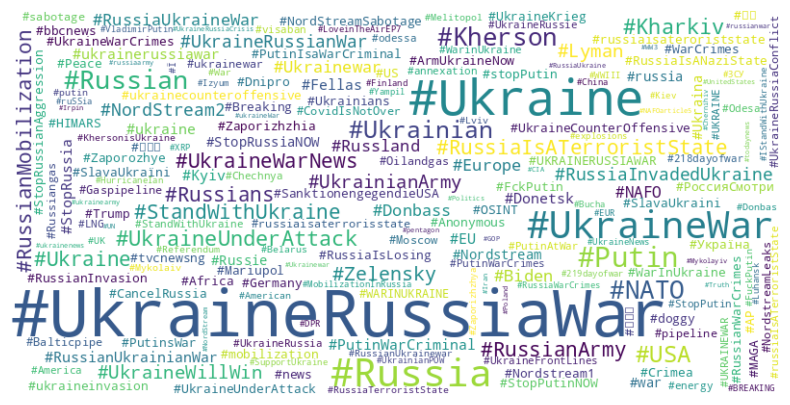

In [ ]:
# Wordcloud to see the more frequent hashtags
dict_hashs_freq = word_count(get_tweets, 'Hashtags')
wordcloud_words(dict_hashs_freq)

###### TOP 50 hashtags in text tweets and their frequency

In [ ]:
# TOP 50 hashtags in text tweets and their frequency
top_x_wc(dict_hashs_freq,50)

--Top 10 words and their frequencies--

Word: #UkraineRussiaWar - Frequency: 3851
Word: #Ukraine - Frequency: 2039
Word: #Russia - Frequency: 1156
Word: #UkraineWar - Frequency: 1101
Word: #Putin - Frequency: 527
Word: #Russian - Frequency: 472
Word: #NATO - Frequency: 439
Word: #Kherson - Frequency: 434
Word: #Ukrainian - Frequency: 407
Word: #USA - Frequency: 382
Word: #Kharkiv - Frequency: 318
Word: #UkraineUnderAttack - Frequency: 311
Word: #UkraineWarNews - Frequency: 273
Word: #RussianArmy - Frequency: 271
Word: #RussianMobilization - Frequency: 269
Word: #RussiaIsATerroristState - Frequency: 257
Word: #StandWithUkraine - Frequency: 250
Word: #Ukraine️ - Frequency: 239
Word: #Russians - Frequency: 235
Word: #Zelensky - Frequency: 215
Word: #Lyman - Frequency: 194
Word: #UkraineWillWin - Frequency: 190
Word: #UkrainianArmy - Frequency: 190
Word: #RussiaInvadedUkraine - Frequency: 172
Word: #NordStream2 - Frequency: 167
Word: #UkraineRussianWar - Frequency: 166
Word: #Biden - Frequ